# Predict equipment failure

According to a study by [Aberdeen](https://www.aberdeen.com/blogposts/stat-of-the-week-the-rising-cost-of-downtime/), unplanned equipment failure can cost up to $260,000 an hour. They also introduce unintended consequences such as downtime, health and safety risks, and inventory damages.

Using AI to automate the predictive maintenance process allows operators to proactively identify subtle or unknown issues with equipment operation in the collected sensor data and schedule maintenance when maintenance is truly needed, or automatically receive notifications to intervene when a sudden failure is imminent. DataRobot models can empower your maintenance staff by providing the information they need to keep operations running without any disruption.

Before proceeding, review the [API quickstart guide](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html) to ensure that your client and API credentials have been properly configured.

To run this notebook on your own, click the download icon in the top right of the page.

## Setup

### Import libraries

In [ ]:
!pip install datarobot umap-learn nbformat openpyxl hdbscan

In [7]:
%matplotlib inline

import datarobot as dr
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

light_blue = "#598fd6"
grey_blue = "#5f728b"
orange = "#dd6b3d"

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [ ]:
# If the config file is not in the default location described in the API Quickstart guide, '~/.config/datarobot/drconfig.yaml', then you will need to call
# dr.Client(config_path='path-to-drconfig.yaml')

### Import data

DataRobot hosts the dataset used in this notebook via the URL used in the snippet below. Read the data directly from the URL into a [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) and display the results to verify all of the data looks correct.

In [4]:
data_path = "https://s3.amazonaws.com/datarobot-use-case-datasets/maintenance_training.csv"

pathfinder_df = pd.read_csv(data_path, encoding="ISO-8859-1")

pathfinder_df.head(100)

lifetime  broken  pressureInd  moistureInd  temperatureInd   team  \
0         56       0    92.178854   104.230204       96.517159  TeamA   
1         81       1    72.075938   103.065701       87.271062  TeamC   
2         60       0    96.272254    77.801376      112.196170  TeamA   
3         86       1    94.406461   108.493608       72.025374  TeamC   
4         34       0    97.752899    99.413492      103.756271  TeamB   
..       ...     ...          ...          ...             ...    ...   
95        41       0    92.453609    92.495352      140.160091  TeamB   
96        12       0   112.047415    89.849594       81.100953  TeamB   
97        65       1   125.032692   101.163482      126.024077  TeamB   
98        80       1    96.008785    84.587554       95.287253  TeamA   
99        93       1   109.671138   104.600332      102.881957  TeamB   

     provider  
0   Provider4  
1   Provider4  
2   Provider1  
3   Provider2  
4   Provider1  
..        ...  
95  Provider2  
96  Provider2  
97  Provider3  
98  Provider1  
99  Provider2  

[100 rows x 7 columns]

### Visualize data

Below, view several examples of charts that visualize the dataset in different ways, such as grouping by provider and part condition.

In [5]:
pathfinder_df["broken_str"] = pathfinder_df["broken"].replace(0, "Not Broken").replace(1, "Broken")

pathfinder_df

lifetime  broken  pressureInd  moistureInd  temperatureInd   team  \
0          56       0    92.178854   104.230204       96.517159  TeamA   
1          81       1    72.075938   103.065701       87.271062  TeamC   
2          60       0    96.272254    77.801376      112.196170  TeamA   
3          86       1    94.406461   108.493608       72.025374  TeamC   
4          34       0    97.752899    99.413492      103.756271  TeamB   
..        ...     ...          ...          ...             ...    ...   
907        88       1    88.589759   112.167556       99.861456  TeamB   
908        88       1   116.727075   110.871332       95.075631  TeamA   
909        22       0   104.026778    88.212873       83.221220  TeamB   
910        78       0   104.911649   104.257296       83.421491  TeamA   
911        63       0   116.901354    99.998694       47.641493  TeamB   

      provider  broken_str  
0    Provider4  Not Broken  
1    Provider4      Broken  
2    Provider1  Not Broken  
3    Provider2      Broken  
4    Provider1  Not Broken  
..         ...         ...  
907  Provider4      Broken  
908  Provider4      Broken  
909  Provider1  Not Broken  
910  Provider4  Not Broken  
911  Provider1  Not Broken  

[912 rows x 8 columns]

In [6]:
df1 = pathfinder_df.where(pathfinder_df["broken"] == 1).groupby("provider").agg({"broken": "count"})
df2 = pathfinder_df.where(pathfinder_df["broken"] == 0).groupby("provider").agg({"broken": "count"})

df_perc = df1 / (df2 + df1)
df_perc = df_perc.reset_index()

df_perc

provider    broken
0  Provider1  0.446903
1  Provider2  0.358025
2  Provider3  0.479452
3  Provider4  0.334821

In [7]:
df1 = pathfinder_df.where(pathfinder_df["broken"] == 1).groupby("team").agg({"broken": "count"})
df2 = pathfinder_df.where(pathfinder_df["broken"] == 0).groupby("team").agg({"broken": "count"})

df_perc = df1 / (df2 + df1)
df_perc = df_perc.reset_index()

df_perc

team    broken
0  TeamA  0.369637
1  TeamB  0.425532
2  TeamC  0.414286

## Modeling
 
For this use case, create a DataRobot project and initiate modeling by running Autopilot in Quick mode.

In [14]:
EXISTING_PROJECT_ID = None  # If you've already created a project, replace None with the ID here
if EXISTING_PROJECT_ID is None:
    # Create project and pass in data
    project = dr.Project.create(sourcedata=pathfinder_df, project_name="Predict equipment failure")

    # Set the project target to the appropriate feature. Use the LogLoss metric to measure performance
    project.set_target(target="broken", mode=dr.AUTOPILOT_MODE.QUICK, worker_count="-1")
else:
    # Fetch the existing project
    project = dr.Project.get(EXISTING_PROJECT_ID)

project.wait_for_autopilot(check_interval=30)

# Get the project metric (i.e LogLoss, RMSE, etc.)
metric = project.metric

In progress: 0, queued: 0 (waited: 0s)


### View project in UI

If you want to view the project in the DataRobot UI, use the following snippet to retrieve the project's URL and use it to navigate to the application.

In [14]:
# Get project URL
project_url = project.get_leaderboard_ui_permalink()
print(project_url)

https://app.datarobot.com/projects/62f2c49067ba04bafdda8972/models


## Evaluate model performance 

To measure model performance, first select the top-performing model based on a specific performance metric (i.e., `LogLoss`) and then evaluate several different types of charts, such as Lift Chart, ROC Curve, and Feature Importance. There are two helper functions that you need to build in order to simplify producing these model insights.

You can reference more information about model evaluation tools [here](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/index.html).

In [11]:
def sorted_by_metric(models, test_set, metric):
    models_with_score = [model for model in models if model.metrics[metric][test_set] is not None]

    return sorted(models_with_score, key=lambda model: model.metrics[metric][test_set])


# Note that this code only works for metrics where lower values indicate better performance
# Reverse to correctly display for metrics where greater values indicate better performance

In [15]:
models = project.get_models()

# Uncomment if this is not set above in the create project cell
metric = project.metric

# Get top performing model
model_top = sorted_by_metric(models, "crossValidation", metric)[0]

print(
    """The top performing model is {model} using metric, {metric}""".format(
        model=str(model_top), metric=metric
    )
)

The top performing model is Model('Elastic-Net Classifier (L2 / Binomial Deviance)') using metric, LogLoss


### Lift Chart

A [lift chart](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/lift-chart.html#lift-chart) shows you how close model predictions are to the actual values of the target in the training data. The lift chart data includes the average predicted value and the average actual values.

In [19]:
# Set styling
dr_dark_blue = "#08233F"
dr_blue = "#1F77B4"
dr_orange = "#FF7F0E"
dr_red = "#BE3C28"

# Create function to build Histograms


def rebin_df(raw_df, number_of_bins):
    cols = ["bin", "actual_mean", "predicted_mean", "bin_weight"]
    new_df = pd.DataFrame(columns=cols)
    current_prediction_total = 0
    current_actual_total = 0
    current_row_total = 0
    x_index = 1
    bin_size = 60 / number_of_bins
    for rowId, data in raw_df.iterrows():
        current_prediction_total += data["predicted"] * data["bin_weight"]
        current_actual_total += data["actual"] * data["bin_weight"]
        current_row_total += data["bin_weight"]

        if (rowId + 1) % bin_size == 0:
            x_index += 1
            bin_properties = {
                "bin": ((round(rowId + 1) / 60) * number_of_bins),
                "actual_mean": current_actual_total / current_row_total,
                "predicted_mean": current_prediction_total / current_row_total,
                "bin_weight": current_row_total,
            }

            new_df = new_df.append(bin_properties, ignore_index=True)
            current_prediction_total = 0
            current_actual_total = 0
            current_row_total = 0
    return new_df

In [18]:
# Create function to build lift charts


def matplotlib_lift(bins_df, bin_count, ax):
    grouped = rebin_df(bins_df, bin_count)
    ax.plot(
        range(1, len(grouped) + 1),
        grouped["predicted_mean"],
        marker="+",
        lw=1,
        color=dr_blue,
        label="predicted",
    )
    ax.plot(
        range(1, len(grouped) + 1),
        grouped["actual_mean"],
        marker="*",
        lw=1,
        color=dr_orange,
        label="actual",
    )
    ax.set_xlim([0, len(grouped) + 1])
    ax.set_facecolor(dr_dark_blue)
    ax.legend(loc="best")
    ax.set_title("Lift chart {} bins".format(bin_count))
    ax.set_xlabel("Sorted Prediction")
    ax.set_ylabel("Value")
    return grouped

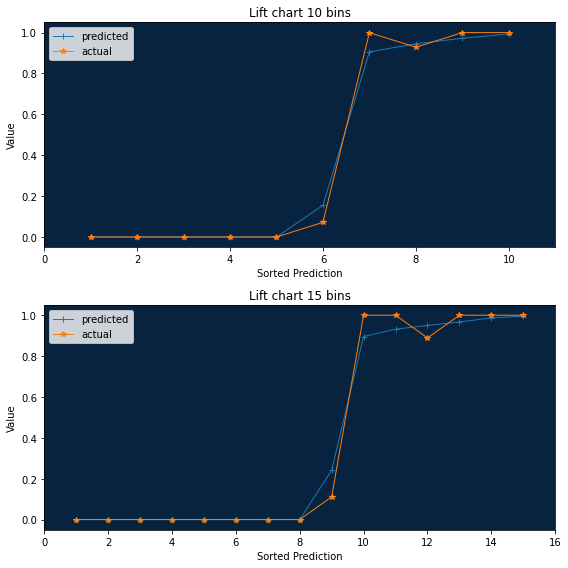

In [19]:
lift_chart = model_top.get_lift_chart("validation")

# Save the result into a pandas dataframe
lift_df = pd.DataFrame(lift_chart.bins)

bin_counts = [10, 15]
f, axarr = plt.subplots(len(bin_counts))
f.set_size_inches((8, 4 * len(bin_counts)))

rebinned_dfs = []
for i in range(len(bin_counts)):
    rebinned_dfs.append(matplotlib_lift(lift_df, bin_counts[i], axarr[i]))

plt.tight_layout()
# plt.show()

### ROC Curve

The receiver operating characteristic curve, or [ROC curve](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/roc-curve-tab/roc-curve.html), is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

In [16]:
roc = model_top.get_roc_curve("validation")

# Save the result into a pandas dataframe
roc_df = pd.DataFrame(roc.roc_points)

roc_df

accuracy  f1_score  false_negative_score  true_negative_score  \
0   0.595890  0.000000                    59                   87   
1   0.602740  0.033333                    58                   87   
2   0.609589  0.065574                    57                   87   
3   0.616438  0.096774                    56                   87   
4   0.623288  0.126984                    55                   87   
..       ...       ...                   ...                  ...   
76  0.883562  0.874074                     0                   70   
77  0.876712  0.867647                     0                   69   
78  0.869863  0.861314                     0                   68   
79  0.863014  0.855072                     0                   67   
80  0.404110  0.575610                     0                    0   

    true_positive_score  false_positive_score  true_negative_rate  \
0                     0                     0            1.000000   
1                     1                     0            1.000000   
2                     2                     0            1.000000   
3                     3                     0            1.000000   
4                     4                     0            1.000000   
..                  ...                   ...                 ...   
76                   59                    17            0.804598   
77                   59                    18            0.793103   
78                   59                    19            0.781609   
79                   59                    20            0.770115   
80                   59                    87            0.000000   

    false_positive_rate  true_positive_rate  matthews_correlation_coefficient  \
0              0.000000            0.000000                          0.000000   
1              0.000000            0.016949                          0.100844   
2              0.000000            0.033898                          0.143109   
3              0.000000            0.050847                          0.175884   
4              0.000000            0.067797                          0.203807   
..                  ...                 ...                               ...   
76             0.195402            1.000000                          0.790330   
77             0.206897            1.000000                          0.779553   
78             0.218391            1.000000                          0.768907   
79             0.229885            1.000000                          0.758386   
80             1.000000            1.000000                          0.000000   

    positive_predictive_value  negative_predictive_value     threshold  \
0                    0.000000                   0.595890  1.000000e+00   
1                    1.000000                   0.600000  9.982433e-01   
2                    1.000000                   0.604167  9.978805e-01   
3                    1.000000                   0.608392  9.974460e-01   
4                    1.000000                   0.612676  9.955975e-01   
..                        ...                        ...           ...   
76                   0.776316                   1.000000  3.757119e-06   
77                   0.766234                   1.000000  3.139812e-06   
78                   0.756410                   1.000000  1.501561e-07   
79                   0.746835                   1.000000  1.079081e-07   
80                   0.404110                   0.000000  1.614430e-33   

    fraction_predicted_as_positive  fraction_predicted_as_negative  \
0                         0.000000                        1.000000   
1                         0.006849                        0.993151   
2                         0.013699                        0.986301   
3                         0.020548                        0.979452   
4                         0.027397                        0.972603   
..                             ...                             .

(0.0, 1.0)

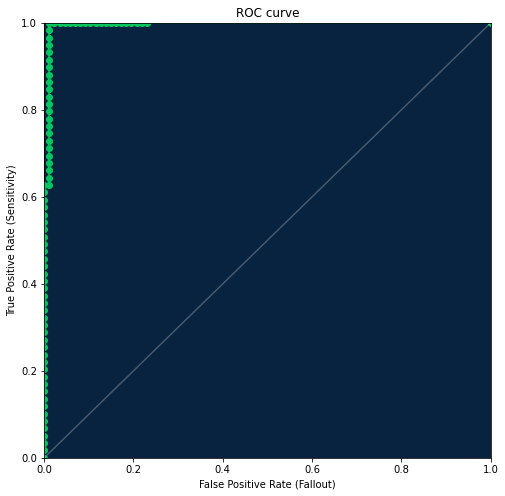

In [21]:
dr_roc_green = "#03c75f"
white = "#ffffff"
dr_purple = "#65147D"
dr_dense_green = "#018f4f"

threshold = roc.get_best_f1_threshold()
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(1, 1, 1, facecolor=dr_dark_blue)

plt.scatter(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot([0, 1], [0, 1], color=white, alpha=0.25)
plt.title("ROC curve")
plt.xlabel("False Positive Rate (Fallout)")
plt.xlim([0, 1])
plt.ylabel("True Positive Rate (Sensitivity)")
plt.ylim([0, 1])

### Feature Impact

[Feature Impact](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html) measures how important a feature is in the context of a model. It measures how much the accuracy of a model would decrease if that feature was removed.

Feature Impact is available for all model types and works by altering input data and observing the effect on a model’s score. It is an on-demand feature, meaning that you must initiate a calculation to see the results. Once DataRobot computes the feature impact for a model, that information is saved with the project.

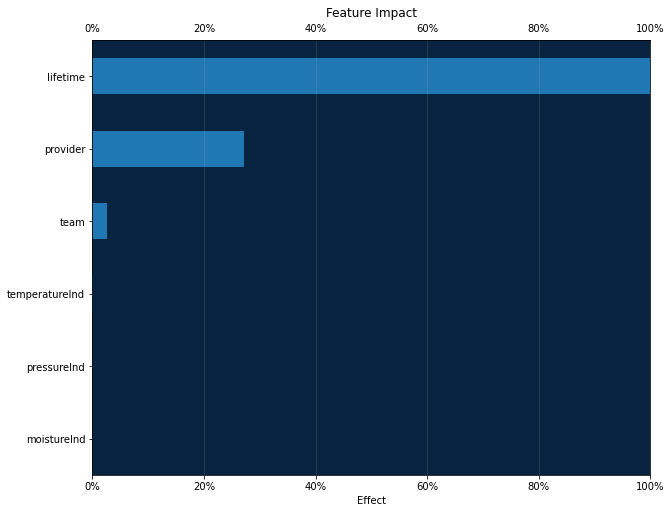

In [21]:
feature_impacts = model_top.get_or_request_feature_impact()

# Limit size to make chart look good. Display top 25 values
if len(feature_impacts) > 25:
    feature_impacts = feature_impacts[0:24]

# Formats the ticks from a float into a percent
percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

impact_df = pd.DataFrame(feature_impacts)
impact_df.sort_values(by="impactNormalized", ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0 else dr_blue)

ax = impact_df.plot.barh(
    x="featureName", y="impactNormalized", legend=False, color=bar_colors, figsize=(10, 8)
)
ax.xaxis.set_major_formatter(percent_tick_fmt)
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.grid(True, alpha=0.2)
ax.set_facecolor(dr_dark_blue)

plt.ylabel("")
plt.xlabel("Effect")
plt.xlim((None, 1))  # Allow for negative impact
plt.title("Feature Impact", y=1.04);

## Make predictions

### Test predictions

After determining the top-performing model from the Leaderboard, upload the prediction test dataset to verify that the model generates predictions successfully before deploying the model to a production environment. The predictions are returned as a Pandas dataframe. 

In [ ]:
data_path_scoring = (
    "https://s3.amazonaws.com/datarobot-use-case-datasets/maintenance_predictions.csv"
)
scoring_df = pd.read_csv(data_path_scoring, encoding="ISO-8859-1")

prediction_dataset = project.upload_dataset(scoring_df)
predict_job = model_top.request_predictions(prediction_dataset.id)
prediction_dataset.id

predictions = predict_job.get_result_when_complete()
pd.concat([scoring_df, predictions], axis=1)
predictions.positive_probability.plot(kind="hist", title="Predicted Probabilities")

### Deploy a model to production


If you are happy with the model's performance, you can deploy it to a production environment with [MLOps](https://docs.datarobot.com/en/mlops/index.html).  Deploying the model will free up workers, as data scored through the deployment doesn't use any modeling workers. Furthermore, you are no longer restricted on the amount of data to score; score over 100GB with the deployment. Deployments also offer many model management benefits: monitoring service, data drift, model comparison, retraining, and more.

In [33]:
# Retrieve a prediction server
prediction_server = dr.PredictionServer.list()[0]

# Get the top performing model. Uncomment if this did not execute in the previous section
# model_top = sorted_by_metric(models, 'crossValidation', metric)[0]

deployment = dr.Deployment.create_from_learning_model(
    model_top.id,
    label="Predictive Maintenance",
    description="Predict Whether a Parts Failure Will Occur",
    default_prediction_server_id=prediction_server.id,
)
deployment.id

Deployment(Late Shipment Predictions)

### Configure batch predictions

After the model has been deployed, DataRobot creates an endpoint for real-time scoring. The deployment allows you to use DataRobot's batch prediction API to score large datasets with a deployed DataRobot model. 

The batch prediction API provides flexible intake and output options when scoring large datasets using prediction servers. The API is exposed through the DataRobot Public API and can be consumed using a REST-enabled client or Public API bindings for DataRobot's Python client.

#### Set the deployment ID

Before proceeding, provide the deployed model's deployment ID (retrieved from the deployment's [Overview tab](https://docs.datarobot.com/en/docs/mlops/monitor/dep-overview.html) or from the Deployment object in the Python client: `deployment.id`).

In [ ]:
deployment_id = "YOUR_DEPLOYMENT_ID"

#### Determine input and output options

DataRobot's batch prediction API allows you to score data from and to multiple sources. You can take advantage of the credentials and data sources you have already established previously through the UI for easy scoring. Credentials are usernames and passwords, while data sources are any databases with which you have previously established a connection (e.g., Snowflake). View the example code below outlining how to query credentials and data sources.

You can reference the full list of DataRobot's supported [input](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/intake-options.html) and [output options](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/output-options.html).

Reference the DataRobot documentation for more information about [data connections](https://docs.datarobot.com/en/docs/data/connect-data/data-conn.html).

The snippet below shows how you can query all credentials tied to a DataRobot account.

In [ ]:
dr.Credential.list()

The output above returns multiple sets of credentials. The alphanumeric string included in each item of the list is the credentials ID. You can use that ID to access credentials through the API.

The snippet below shows how you can query all data sources tied to a DataRobot account. The second line lists each datastore with an alphanumeric string; that is the datastore ID.

In [6]:
dr.DataStore.list()
print(dr.DataStore.list()[0].id)

5e6696ff820e737a5bd78430


### Scoring examples

The snippets below demonstrate how to score data with the Batch Prediction API. Edit the `intake_settings` and `output_settings` to suit your needs. You can mix and match until you get the outcome you prefer.

#### Score from CSV to CSV

In [ ]:
# Scoring without Prediction Explanations
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "localFile",
            "file": "inputfile.csv",  # Provide the filepath, Pandas dataframe, or file-like object here
        },
        output_settings={"type": "localFile", "path": "outputfile.csv"},
    )

# Scoring with Prediction Explanations
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "localFile",
            "file": "inputfile.csv",  # Provide the filepath, Pandas dataframe, or file-like object here
        },
        output_settings={"type": "localFile", "path": "outputfile.csv"},
        max_explanations=3,  # Compute Prediction Explanations for the amount of features indicated here
    )

#### Score from S3 to S3

In [ ]:
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "s3",
            "url": "s3://theos-test-bucket/lending_club_scoring.csv",  # Provide the URL of your datastore here
            "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",  # Provide your credentials here
        },
        output_settings={
            "type": "s3",
            "url": "s3://theos-test-bucket/lending_club_scored2.csv",
            "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",
        },
    )

#### Score from JDBC to JDBC

In [ ]:
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "jdbc",
            "table": "table_name",
            "schema": "public",
            "dataStoreId": data_store.id,  # Provide the ID of your datastore here
            "credentialId": cred.credential_id,  # Provide your credentials here
        },
        output_settings={
            "type": "jdbc",
            "table": "table_name",
            "schema": "public",
            "statementType": "insert",
            "dataStoreId": data_store.id,
            "credentialId": cred.credential_id,
        },
    )